In [1]:
import os
import re
import _pickle as cPickle
from collections import OrderedDict, defaultdict, Counter

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize

from data_structure import Instance

# configure

In [246]:
def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()    
    keys_list = [keys for keys in flags_dict]    
    for keys in keys_list:
        FLAGS.__delattr__(keys)

del_all_flags(tf.flags.FLAGS)

flags = tf.app.flags

flags.DEFINE_string('data_path', 'data/bags/bags.trn', 'path of input data')

flags.DEFINE_string('stopwords_path', 'data/stopwords_mallet.txt', 'path of input data')

flags.DEFINE_string('ref_dir', 'data/bags/ref', 'directory of ref summaries')
flags.DEFINE_string('output_path', 'data/bags/instances.pkl', 'path of output data')

flags.DEFINE_integer('n_vocab', 50000, 'size of vocab')

flags.DEFINE_string('f', '', 'kernel')

config = flags.FLAGS

In [247]:
# special tokens
PAD = '<pad>' # This has a vocab id, which is used to pad the encoder input, decoder input and target sequence
UNK = '<unk>' # This has a vocab id, which is used to represent out-of-vocabulary words
BOS = '<p>' # This has a vocab id, which is used at the beginning of every decoder input sequence
EOS = '</p>' # This has a vocab id, which is used at the end of untruncated target sequences
dummy_tokens = [PAD, UNK, BOS, EOS]

# load source

In [21]:
with open(config.data_path, 'r') as f:
    txt = f.read()

In [27]:
docs = txt.split('\n\n')[:-1]

In [53]:
def preprocess(line):
    line = re.sub(r'EDU_BREAK ', ' ', line)
    line = re.sub(r'[0-9]+.[0-9]+|[0-9]+,[0-9]+|[0-9]+', '#', line)
    line = line.lower()
    return line

In [207]:
docs_lines = [doc.split('\n') for doc in docs]
data_dict_list = [{'review_idx': doc_lines[0].split(' ')[0], 'score': doc_lines[0].split(' ')[1], 'lines': [preprocess(line) for line in doc_lines[1:]]} for doc_lines in docs_lines]
data_df = pd.DataFrame(data_dict_list)

In [208]:
get_tokens = lambda lines: [word_tokenize(line.lower())[:-1] for line in lines]
data_df['tokens'] = data_df['lines'].apply(get_tokens)
filter_tokens = lambda tokens: [line_tokens for line_tokens in tokens if len(line_tokens) > 2]
data_df['tokens'] = data_df['tokens'].apply(filter_tokens)

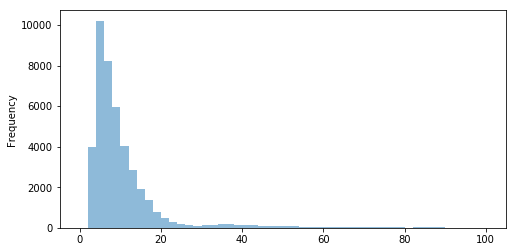

In [213]:
data_df['tokens'].apply(lambda tokens: min([len(line) for line in tokens])).plot(bins=50, alpha=0.5, figsize=(8,4), kind='hist', range=(0, 100));

In [214]:
data_df['doc_l'] = data_df['tokens'].apply(lambda tokens: len(tokens))
data_df['max_sent_l'] = data_df['tokens'].apply(lambda tokens: max([len(line) for line in tokens]))

In [215]:
data_df['item_idx'] = data_df['review_idx'].apply(lambda review_idx: review_idx.split('-')[0])
data_df['doc'] = data_df['lines'].apply(lambda lines: ' '.join(lines))

In [217]:
len(data_df)

42632

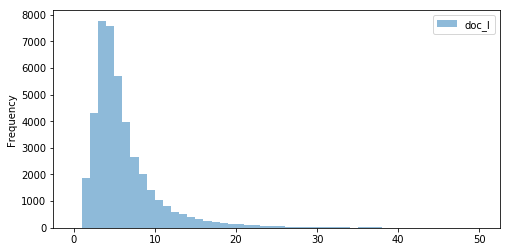

In [218]:
data_df.plot(y=['doc_l'], bins=50, alpha=0.5, figsize=(8,4), kind='hist', range=(0, 50));

In [219]:
np.sum(data_df['doc_l'] <= 10) / len(data_df)

0.8981281666353913

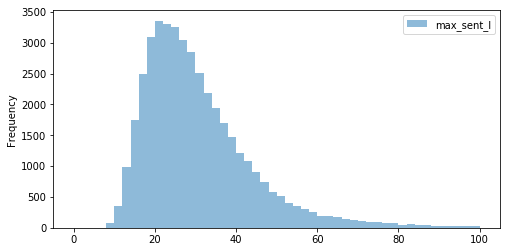

In [220]:
data_df.plot(y=['max_sent_l'], bins=50, alpha=0.5, figsize=(8,4), kind='hist', range=(0, 100));

In [221]:
np.sum(data_df['max_sent_l'] <= 40) / len(data_df)

0.8207684368549446

In [222]:
filtered_data_df = data_df[(data_df['doc_l'] <= 10) & (data_df['max_sent_l'] <= 40)]
len(filtered_data_df)

32518

# split data_df

In [338]:
test_item_idxs = []
item_idx_summaries = defaultdict(list)
for fname in os.listdir(config.ref_dir):
    test_item_idx = re.search(r'bags_and_cases.([A-Z0-9]+).*.all.txt', fname).group(1)
    test_item_idxs.append(test_item_idx)
    
    fpath = os.path.join(config.ref_dir, fname)
    with open(fpath, 'r') as f:
        summary = f.read()
    item_idx_summaries[test_item_idx].append(summary)
test_item_idxs = set(test_item_idxs)
len(test_item_idxs)

10

In [293]:
item_idxs = set(data_df['item_idx'])
train_dev_item_idxs = list(item_idxs - test_item_idxs)
len(train_dev_item_idxs)

2031

In [310]:
test_df = filtered_data_df[filtered_data_df['item_idx'].apply(lambda item_idx: item_idx in test_item_idxs)]
valid_df = filtered_data_df[filtered_data_df['item_idx'].apply(lambda item_idx: item_idx in train_dev_item_idxs[:30])]
train_df = filtered_data_df[filtered_data_df['item_idx'].apply(lambda item_idx: item_idx in train_dev_item_idxs[10:])]
len(train_df), len(valid_df), len(test_df)

(31943, 385, 416)

# build vocab for language modeling 

In [311]:
def get_word_cnt_dict(train_df, min_tf=None):
    # create vocab of words
    word_cnt_dict = defaultdict(int)
    word_cnt_dict['.'] = np.inf
    word_cnt_dict[EOS] = np.inf
    word_cnt_dict[BOS] = np.inf
    word_cnt_dict[UNK] = np.inf
    word_cnt_dict[PAD] = np.inf
    
    tokens_list = []
    for doc in train_df.tokens:
        tokens_list.extend(doc)
    
    for tokens in tokens_list:
        for word in tokens:
            word_cnt_dict[word] += 1
    word_cnt_dict = sorted(word_cnt_dict.items(), key=lambda x: x[1])[::-1]
    
    if type(min_tf) is int:
        word_cnt_dict = list(filter(lambda x: x[1] >= min_tf, word_cnt_dict))
    elif type(min_tf) is float:
        word_cnt_dict = word_cnt_dict[:int(min_tf*len(word_cnt_dict))]
    return word_cnt_dict

In [312]:
word_cnt_dict = get_word_cnt_dict(train_df, min_tf=3)
print(len(word_cnt_dict), len(get_word_cnt_dict(train_df, min_tf=0)))

9187 24143


In [313]:
idx_to_word = {idx: word for idx, (word, cnt) in enumerate(word_cnt_dict)}
word_to_idx = {word: idx for idx, word in idx_to_word.items()}

# build bow vector

In [321]:
stop_word_cnt_dict = get_word_cnt_dict(train_df, min_tf=0.003)
len(stop_word_cnt_dict)
stop_word_cnt_dict

[('<pad>', inf),
 ('<unk>', inf),
 ('<p>', inf),
 ('</p>', inf),
 ('.', inf),
 ('the', 111879),
 ('it', 81471),
 ('i', 79097),
 (',', 68687),
 ('and', 64002),
 ('a', 60617),
 ('to', 46056),
 ('is', 44618),
 ('for', 38817),
 ('this', 37206),
 ('#', 34880),
 ('my', 33611),
 ('of', 28139),
 ('in', 21559),
 ('that', 20855),
 ('case', 20791),
 ('but', 18993),
 ('bag', 17701),
 ('on', 17672),
 ('laptop', 17486),
 ('with', 17067),
 ('was', 16777),
 ('not', 15996),
 ('have', 14195),
 ("n't", 13615),
 ('you', 12285),
 ("'s", 12241),
 ('very', 11993),
 ('as', 11237),
 ('so', 10425),
 ('great', 9700),
 ('like', 9466),
 ('would', 9414),
 ('one', 9067),
 ('has', 8675),
 ('well', 8442),
 ('be', 8335),
 ('fit', 8280),
 ('just', 7768),
 ('fits', 7533),
 ('all', 7467),
 ('if', 7225),
 ('are', 7195),
 ('macbook', 7048),
 ('good', 7016),
 ('does', 6709),
 ('when', 6423),
 ('had', 6338),
 ('from', 5980),
 ('do', 5923),
 ('or', 5875),
 ('there', 5714),
 ('use', 5691),
 ('only', 5637),
 ('more', 5617),
 ('-

In [322]:
with open(config.stopwords_path, 'r') as f:
    stop_words_mallet = [w.replace('\n', '') for w in f.readlines()]
len(stop_words_mallet)

524

In [323]:
stop_words = stop_words_mallet + [w_cnt[0] for w_cnt in stop_word_cnt_dict if w_cnt[0] not in dummy_tokens]
len(stop_words)

592

In [324]:
train_corpus = list(train_df.doc)
valid_corpus = list(valid_df.doc)
test_corpus = list(test_df.doc)

In [325]:
vectorizer = TfidfVectorizer(min_df=100, max_df=1.0, stop_words=stop_words, tokenizer=word_tokenize, norm=None, use_idf=False, dtype=np.float32)
train_bow_list = vectorizer.fit_transform(train_corpus)
bow_tokens = vectorizer.get_feature_names()
print(len(bow_tokens))
assert len(train_df) == len(train_bow_list.toarray())
assert all([word in word_to_idx for word in bow_tokens])

1035


In [326]:
valid_bow_list = vectorizer.transform(valid_corpus)
test_bow_list = vectorizer.transform(test_corpus)

In [327]:
bow_idxs = np.array([word_to_idx[token] for token in bow_tokens])

## check

In [328]:
sample_doc_idx = 1
sample_doc = train_corpus[sample_doc_idx]
sample_tokens = word_tokenize(sample_doc)
filtered_tokens = [w for w in sample_tokens if (w not in vectorizer.stop_words_) and (w not in stop_words)]
assert all([word in bow_tokens for word in filtered_tokens])

filtered_word_cnt_dict = Counter(filtered_tokens)
pseudo_bow = np.array([float(filtered_word_cnt_dict[w]) if w in filtered_word_cnt_dict else 0. for w in bow_tokens])
# pseudo_bow = pseudo_bow / np.sum(pseudo_bow)

sample_bow = train_bow_list.toarray()[sample_doc_idx]
np.max((sample_bow - pseudo_bow)**2)

0.0

In [329]:
np.where(pseudo_bow>0)

(array([   0,   11,   37,   94,  100,  120,  128,  142,  237,  245,  248,
         268,  337,  390,  428,  448,  478,  568,  628,  644,  728,  810,
         861,  891,  934, 1017, 1029]),)

In [330]:
np.where(sample_bow>0)

(array([   0,   11,   37,   94,  100,  120,  128,  142,  237,  245,  248,
         268,  337,  390,  428,  448,  478,  568,  628,  644,  728,  810,
         861,  891,  934, 1017, 1029]),)

# write out

In [342]:
def prepare_instances(data_df, word_to_idx, bow_list, item_idx_summaries=None):
    instances = []
    bows = bow_list.toarray()
    assert len(bows) == len(data_df)
    for bow, (idx_doc, doc) in zip(bows, data_df.iterrows()):
        instance = Instance()
        instance.idx = idx_doc
        instance.review_idx = doc.review_idx
        instance.item_idx = doc.item_idx
        instance.score = doc.score
        doc_token_idxs = []
        for sent_tokens in doc.tokens:
            sent_token_idxs = [word_to_idx[token] if token in word_to_idx else word_to_idx[UNK] for token in sent_tokens]
            doc_token_idxs.append(sent_token_idxs)            
        instance.token_idxs = doc_token_idxs
        instance.doc_l = doc.doc_l
        instance.max_sent_l = doc.max_sent_l
        instance.bow = bow
        if item_idx_summaries:
            instance.summaries = item_idx_summaries[instance.item_idx]
        instances.append(instance)
    return instances

In [343]:
instances_train = prepare_instances(train_df, word_to_idx, train_bow_list)
instances_valid = prepare_instances(valid_df, word_to_idx, valid_bow_list)
instances_test = prepare_instances(test_df, word_to_idx, test_bow_list, item_idx_summaries)

In [344]:
print('saving preprocessed instances...')
cPickle.dump((instances_train, instances_valid, instances_test, word_to_idx, idx_to_word, bow_idxs),open(config.output_path,'wb'))

saving preprocessed instances...
